In [2]:
import datetime as dt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

from flask import Flask, jsonify

import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

In [3]:
# db setup
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect the db into new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# saving the reference to the tables
Measurement = Base.classes.measurements
Station = Base.classes.station

In [6]:
# create the session; link from python to db
session = Session(bind = engine)

In [7]:
# getting table names for each table
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'measurements_table', 'station']

In [8]:
# prcp & date for last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2017-05-01')

In [9]:
# create empty dict to load data
last_twelve_data = {'date': [], 'prcp': []}

# load data into dict with rows from results
for row in results:
    last_twelve_data['date'].append(row.date)
    last_twelve_data['prcp'].append(row.prcp)

# create df from dict
last_twelve_df = pd.DataFrame(last_twelve_data['prcp'], columns = ['prcp'], index = last_twelve_data['date'])
print(last_twelve_df.head())

            prcp
2017-05-01  0.26
2017-05-02  0.00
2017-05-03  0.00
2017-05-04  0.00
2017-05-05  0.00


In [10]:
# create empty dict to load data
plot_prcp_data = {'date': [], 'prcp': []}

# load data into dict with rows from results
for row in results:
    plot_prcp_data['date'].append(row.date)
    plot_prcp_data['prcp'].append(row.prcp)

In [11]:
plot_prcp_df = pd.DataFrame.from_dict(plot_prcp_data)

In [12]:
plot_prcp_df.set_index('date').head()

,prcp
date,
2017-05-01,0.26
2017-05-02,0.00
2017-05-03,0.00
2017-05-04,0.00
2017-05-05,0.00


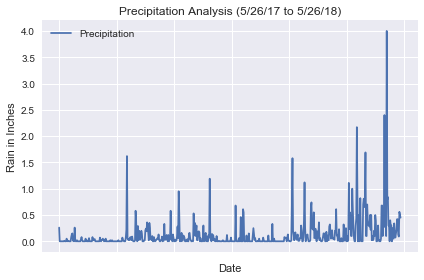

In [13]:
# plot the dataframe
plot_prcp_df.plot('date')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (5/26/17 to 5/26/18)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Count the number of stations in the Measurement table
locations = session.query(Station).group_by(Station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [29]:
# busiest station; list all others in descending order
busy_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_stations[0][0]    
print("The busiest station was",busiest,". It had",busy_stations[0][1],"observations.")
print()
print("All stations (in descending order):")
for station, count in busy_stations:
    print("Station",station,"had",count, "weather observations.")

The busiest station was USC00519281 . It had 2772 observations.

All stations (in descending order):
Station USC00519281 had 2772 weather observations.
Station USC00513117 had 2696 weather observations.
Station USC00519397 had 2685 weather observations.
Station USC00519523 had 2572 weather observations.
Station USC00516128 had 2484 weather observations.
Station USC00514830 had 1937 weather observations.
Station USC00511918 had 1932 weather observations.
Station USC00517948 had 683 weather observations.
Station USC00518838 had 342 weather observations.


In [31]:
# last year of precipitation data for the busiest station
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date >= '2017-05-26').\
    order_by(Measurement.date).all()

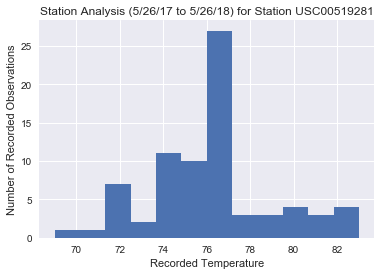

In [32]:
# plot the temperature data
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (5/26/17 to 5/26/18) for Station " + busiest)
plt.show()

In [38]:
# function: accept start date and end date in the format '%Y-%m-%d'; 
# return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    temp_range = (calc_temps('2017-05-26', '2018-05-26'))
print(temp_range)

[(62, 69.3921568627451, 74)]


In [39]:
trip_arrive = dt.date(2017, 5, 26)
trip_leave = dt.date(2017, 6, 4)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(65, 73.29629629629629, 81)]


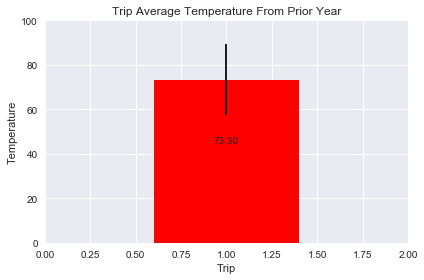

In [41]:
# plot the data

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()